# Measuring and logging the CPU usage at the `hpc05`

Takes a measuring point **every 15 minutes** and then updates this website.

Want to know something? Ask/e-mail Bas at [basnijholt@gmail.com](mailto:basnijholt@gmail.com).

In [ ]:
import datetime
tz = datetime.timezone(datetime.timedelta(hours=2))
print('Last time this script ran is at {}'.format(str(datetime.datetime.now(tz))))

# Current usage at the `hpc05`

In [ ]:
!ssh hpc05 'bash -c "~/miniconda3/envs/dev/bin/python /home/basnijholt/Work/cluster_log/stat.py"'

In [98]:
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def open_json(fname):
    with open(fname, 'r') as f:
        x = json.load(f)

    data = []
    for key, val in x.items():
        ID, user, process = key.split()
        for i in val:
            current_time, actual_usage_time, num_cores = i
            data.append(dict(ID=ID, user=user, process=process, current_time=current_time, 
                        actual_usage_time=actual_usage_time, num_cores=num_cores))
    return data


def load_file_sort_by_ID(data, today=False):
    df = pd.DataFrame(data)
    by_ID = df.groupby('ID')
    df['reserved_time'] = by_ID['current_time'].transform(lambda x: x-x.min())
    df['actual_usage_time'] = by_ID['actual_usage_time'].transform(lambda x: x-x.min())
    df['actual_usage_time'] = df['actual_usage_time'] / df['num_cores']
    df['activity'] = df['actual_usage_time'] / df['reserved_time'] * 100
    df.index = pd.to_datetime(df.pop('current_time'), unit='s', utc=True)
    df = df.sort_index()
    if today:
        # select only today
        df = df.loc[str(datetime.date.today())]
        by_ID = df.groupby('ID')
    lasts = by_ID.last().set_index('user')
    return df, lasts


def get_user_df(lasts):
    by_user = lasts.groupby(level='user')
    reserved_days = by_user.apply(lambda x: (x.reserved_time * x.num_cores).sum() / 86400)
    actual_usage_days = by_user.apply(lambda x: (x.actual_usage_time * x.num_cores).sum() / 86400)
    idle_days = reserved_days - actual_usage_days
    user_df = reserved_days.to_frame('reserved_days').join(actual_usage_days.to_frame('actual_usage_days')).join(idle_days.to_frame('idle_days'))
    user_df['activity'] = user_df.actual_usage_days / user_df.reserved_days * 100
    return user_df

today = str(datetime.date.today())
month = datetime.datetime.today().strftime("%B")
data = open_json('job_log_{}.json'.format(today[:-3]))

# This months data

* `reserved_days` means the total amount of CPU time (in days) that the user *reserved* the cores.
* `actual_usage_days` means the total amount of CPU time (in days) that the user was *actually* using the cores.
* `idle_days = reserved_days - actual_usage_days`

In [99]:
df, lasts = load_file_sort_by_ID(data, today=False)
user_df = get_user_df(lasts)
user_df.sort_values('idle_days', ascending=False)

,reserved_days,actual_usage_days,idle_days,activity
user,,,,
jcelisgil,1210.369380,180.792037,1029.577343,14.936931
jvandermaes,914.093943,75.330556,838.763387,8.241008
basnijholt,1161.135214,812.482488,348.652726,69.973116
dsticlet,346.075599,181.774815,164.300784,52.524597
mirfan,97.374413,4.835625,92.538788,4.966012
mhuibers,240.504402,178.689236,61.815166,74.297699
kristianblo,232.933024,173.012280,59.920744,74.275548
trosdahl,343.540622,320.680370,22.860251,93.345692
srubbert,53.046528,33.878113,19.168414,63.864903


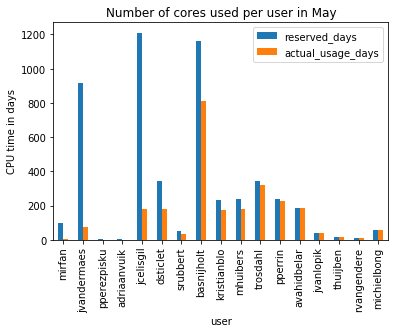

In [100]:
ax = user_df.sort_values('activity').plot.bar(y=['reserved_days', 'actual_usage_days'])
ax.set_ylabel('CPU time in days')
ax.set_title('Number of cores used per user in {}'.format(month))

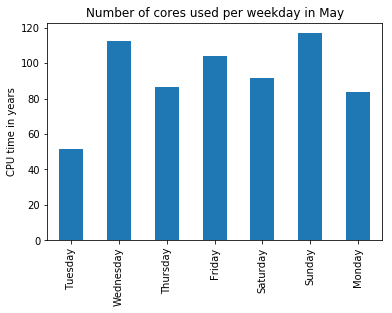

In [101]:
ax = df.groupby(df.index.weekday_name, sort=False).actual_usage_time.sum().divide(86400 * 365).plot.bar()
ax.set_ylabel('CPU time in years')
ax.set_title('Number of cores used per weekday in {}'.format(month))

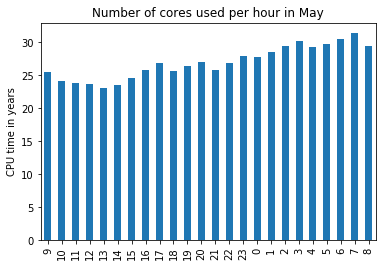

In [102]:
ax = df.groupby(df.index.hour, sort=False).actual_usage_time.sum().divide(86400 * 365).plot.bar()
ax.set_ylabel('CPU time in years')
ax.set_title('Number of cores used per hour in {}'.format(month))

# Only today

In [104]:
df, lasts = load_file_sort_by_ID(data, today=True)
user_df_today = get_user_df(lasts)
user_df_today.sort_values('idle_days', ascending=False)

,reserved_days,actual_usage_days,idle_days,activity
user,,,,
jcelisgil,794.834868,41.746759,753.088109,5.252256
jvandermaes,217.477629,17.112662,200.364967,7.868700
dsticlet,21.043069,0.901910,20.141159,4.286018
srubbert,10.111113,0.003889,10.107224,0.038462
pperrin,190.000356,183.774525,6.225831,96.723253
adriaanvuik,1.711406,0.238056,1.473351,13.909938
trosdahl,120.989665,119.798403,1.191262,99.015402
kristianblo,74.050395,74.011690,0.038705,99.947731
thuijben,4.597239,4.594734,0.002505,99.945513


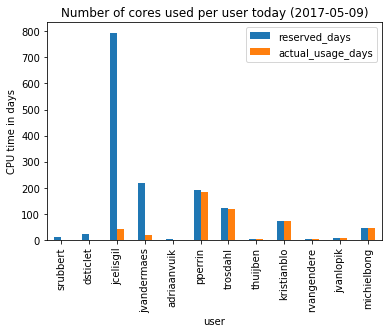

In [105]:
ax = user_df_today.sort_values('activity').plot.bar(y=['reserved_days', 'actual_usage_days'])
ax.set_ylabel('CPU time in days')
ax.set_title('Number of cores used per user today ({})'.format(today))